In [1]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import os

%matplotlib inline

In [2]:
def read_hbond(dhout):
    '''
    read the output file of cpptraj hbond analysis
    '''
    with open(dhout,'r') as f:
        alllines = f.readlines()
        
    pair = {i:[int(j.split("_")[1][0:3]),int(j.split("_")[2][0:3])] \
            for i, j in enumerate(alllines) if i > 0 }
    dhresidue = pd.DataFrame(pair,index=['First Residue', 'Second Residue']).T
    
    return dhresidue
    
    

In [3]:
def read_backbond_hbond(inputfile,fraction=0.1):
    '''
    read the hbonds containing amide hdrogen.
    When amide H is involved in H-bonding, then it 
    will be protected from HXMS spectrum
    
    Now only output Hbonds with 10% fraction..
    '''
    with open(inputfile,'r') as f:
        alllines = f.readlines()
        
    #only read hbonds with amide Hydrogen 
    # and fractoin > 0.1
    def select_hydrogen():
        selec_ix = []
        for i,j in enumerate(alllines):
            if i > 0:
                N_name = j.split("@")[3][0]
                Frac = float(j.split()[4])
                if N_name == 'N' and Frac >= fraction:
                    selec_ix.append(i)
        return selec_ix
    
    idx = select_hydrogen()
    
    def get_unique_pair(residuepairs):
        '''
        there may exist multiple hbonds within one residue pair,
        only select the Hbond with largest fraction in this case
        '''
        grouped = residuepairs.groupby(['F resi','S resi'])
        idx = grouped['Fraction'].idxmax()
        temp = residuepairs.loc[idx]
        return temp.sort_values(by='Fraction',ascending=False).reset_index(drop=True)
        
    def get_residue(idx):
        residue=[]
        for i in idx:
            string = alllines[i].split("_")
            first_residue = min(int(string[1][0:3]),int(string[2][0:3]))
            second_residue = max(int(string[1][0:3]),int(string[2][0:3]))
            Frac = float(alllines[i].split()[4])
            if abs(first_residue-second_residue) != 0 :
                residue.append([first_residue,second_residue,Frac])
                
        df = pd.DataFrame(residue,columns=['F resi','S resi','Fraction'])
        return get_unique_pair(df)

            
    
    dhdata = get_residue(idx)
    
    return dhdata
            

In [4]:
print (os.getcwd())

/home/AD/bsu233/plotfigures/CaMDH/backbone_dh


In [5]:
case = ['siteA','siteB','siteC','siteD','K30E','G40D','A454E']

cwd=os.getcwd()
def setdatafile(cases):
    return os.path.join(cwd,'data/'+cases+'/avout') # os.path.join() dir2 can not preceeds with '/'


In [6]:
dhdata={i:read_backbond_hbond(setdatafile(i)) for i in case}

In [7]:
# map residue to original CaN residue number
for i in dhdata.keys():
    dhdata[i]['F resi'] = dhdata[i]['F resi'].map(lambda x: x+245)
    dhdata[i]['S resi'] = dhdata[i]['S resi'].map(lambda x: x+245)

In [8]:
starting_resi = 415
frag_fasta="EESESVLTLKGLTPTGMLPSGVLSGGKQTLQSATVEAIEADEAI" # starting from 415 to 458
Residues = {i+starting_resi: j+str(i+starting_resi) for i,j in enumerate(frag_fasta)}
print (Residues)

{415: 'E415', 416: 'E416', 417: 'S417', 418: 'E418', 419: 'S419', 420: 'V420', 421: 'L421', 422: 'T422', 423: 'L423', 424: 'K424', 425: 'G425', 426: 'L426', 427: 'T427', 428: 'P428', 429: 'T429', 430: 'G430', 431: 'M431', 432: 'L432', 433: 'P433', 434: 'S434', 435: 'G435', 436: 'V436', 437: 'L437', 438: 'S438', 439: 'G439', 440: 'G440', 441: 'K441', 442: 'Q442', 443: 'T443', 444: 'L444', 445: 'Q445', 446: 'S446', 447: 'A447', 448: 'T448', 449: 'V449', 450: 'E450', 451: 'A451', 452: 'I452', 453: 'E453', 454: 'A454', 455: 'D455', 456: 'E456', 457: 'A457', 458: 'I458'}


In [20]:
# print the number of Hbbonds with fraction > 10% for each case
for i in dhdata.keys():
    print ('%s has %d backbone Hbonds' % (i,len(dhdata[i])))

siteA has 10 backbone Hbonds
siteB has 16 backbone Hbonds
siteC has 9 backbone Hbonds
siteD has 16 backbone Hbonds
K30E has 14 backbone Hbonds
G40D has 14 backbone Hbonds
A454E has 24 backbone Hbonds


In [19]:
dhdata['siteD']

,F resi,S resi,Fraction
0,432,436,0.6709
1,432,435,0.6203
2,452,456,0.4460
3,449,453,0.4303
4,430,438,0.4101
5,415,418,0.2110
6,448,451,0.1876
7,415,419,0.1817
8,421,424,0.1371
9,452,455,0.1313


In [11]:
from matplotlib import colors
from matplotlib import rcParams
rcParams['figure.figsize']=20,1

In [12]:
def draw_hbond_figure(residues,hbondata):
    '''
    Show the hydrogen bonding in a fancy way..
    '''
    # create discrete colormap
    cmap = colors.ListedColormap(['silver'])
    bounds = [0,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()


    n=len(residues)
    data=np.ones((4,n))
    ax.imshow(data, cmap=cmap, norm=norm)
    ax.set_yticks([-0.5,2.5])
    ax.yaxis.set_visible(False)
    ax.set_xticks(np.arange(0,n)+0.5)
    ax.set_xticklabels([])
    ax.set_ylim(ax.get_ylim()[::-1])
    # draw gridlines
    ax.grid(which='major', axis='x', linestyle='-', color='k', linewidth=1)
    ax.text(1,-0.8,'E415',va="top", ha="right",fontsize=10,color='red')
    ax.text(44,-0.8,'I458',va="top", ha="right",fontsize=10,color='red')
    ax.text(27,-0.8,'K441',va="top", ha="right",fontsize=10,color='red')
    
    maxvalue = 0.7
    cm = plt.get_cmap('jet')
    #fig.colorbar(ax,cm)
    #ax.colorbar()
    hdcay = 0.25 # the decay of line hight
    Height=3.5
    for i in range(len(hbondata['F resi'])):
        H = Height-(i+1)*hdcay
        startpoint = min(hbondata['F resi'][i]-starting_resi,hbondata['S resi'][i] - starting_resi)
        endpoint = max(hbondata['F resi'][i]-starting_resi,hbondata['S resi'][i] - starting_resi)
        value = hbondata['Fraction'][i]
        color = cm(value/maxvalue)
        
        ax.annotate("", xy=(startpoint, H), xycoords='data',\
             xytext=(endpoint, H), textcoords='data',\
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3",color=color,))

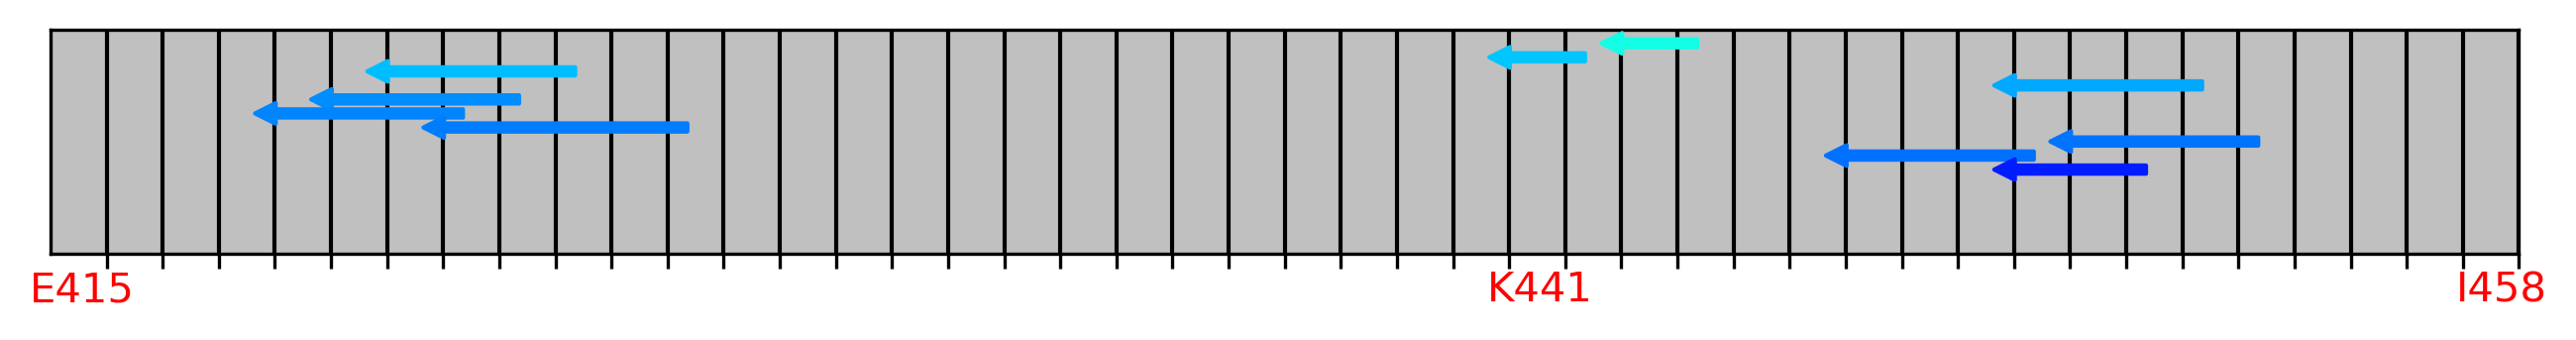

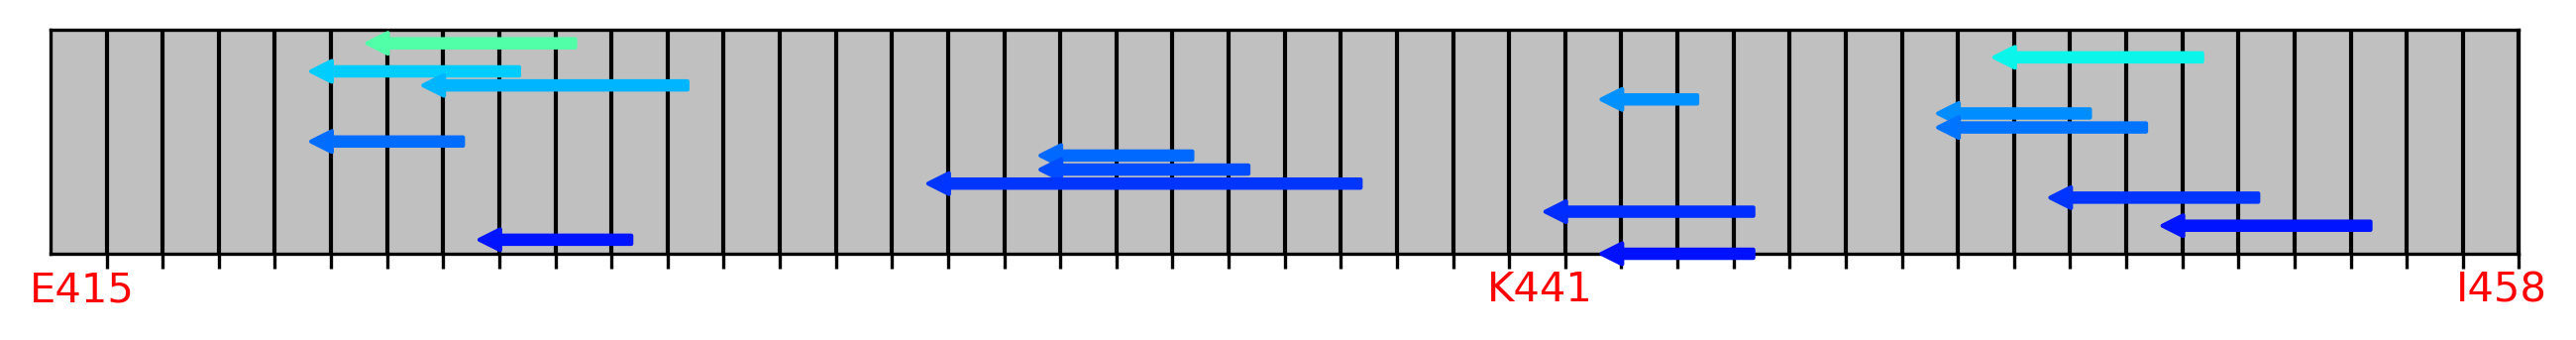

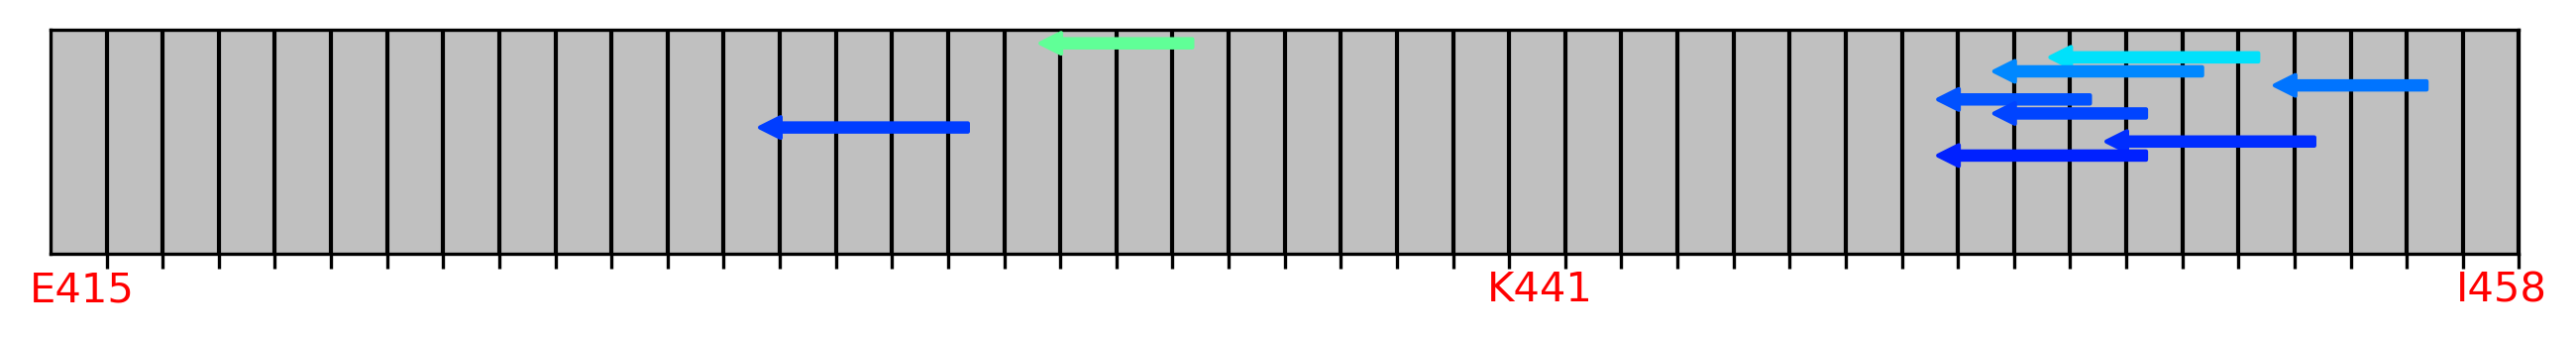

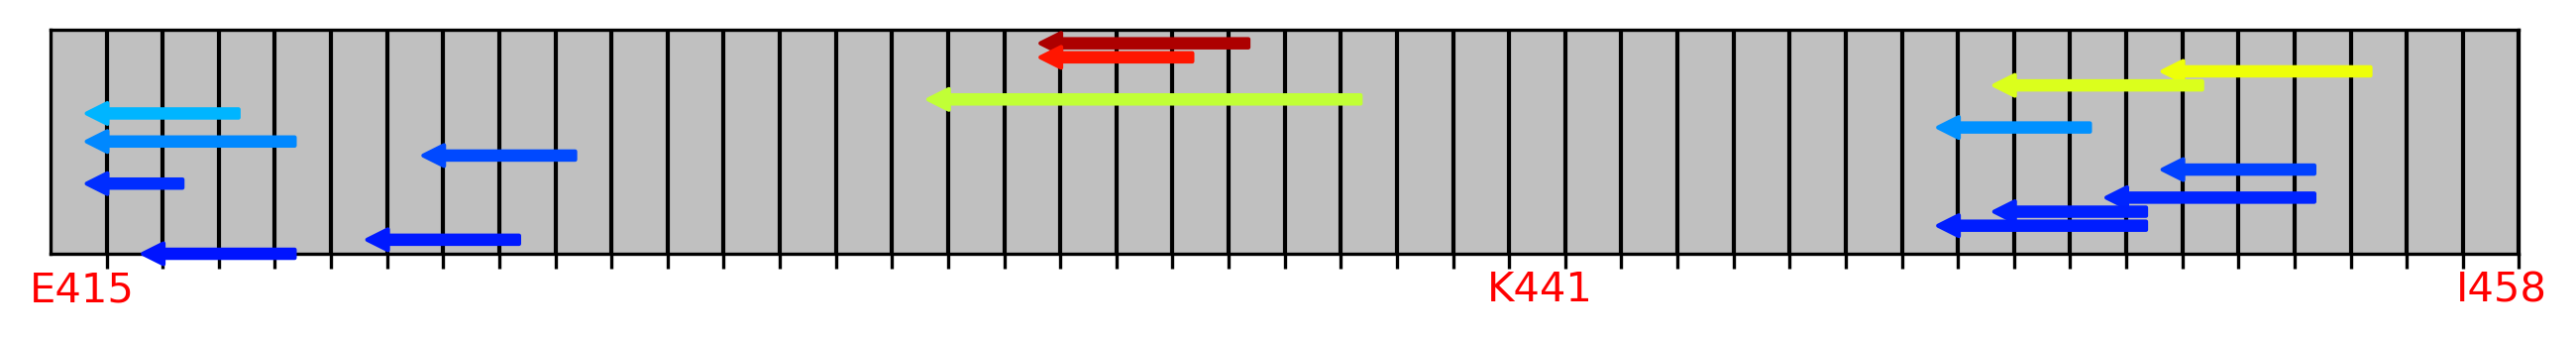

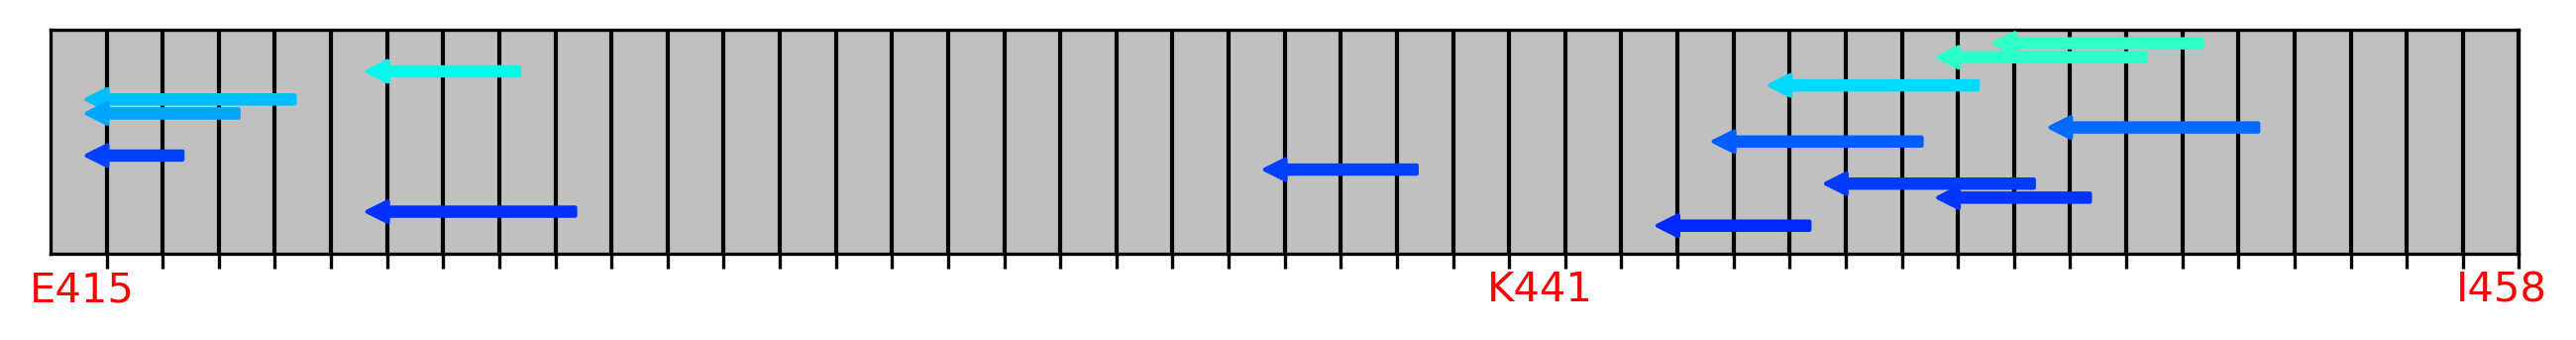

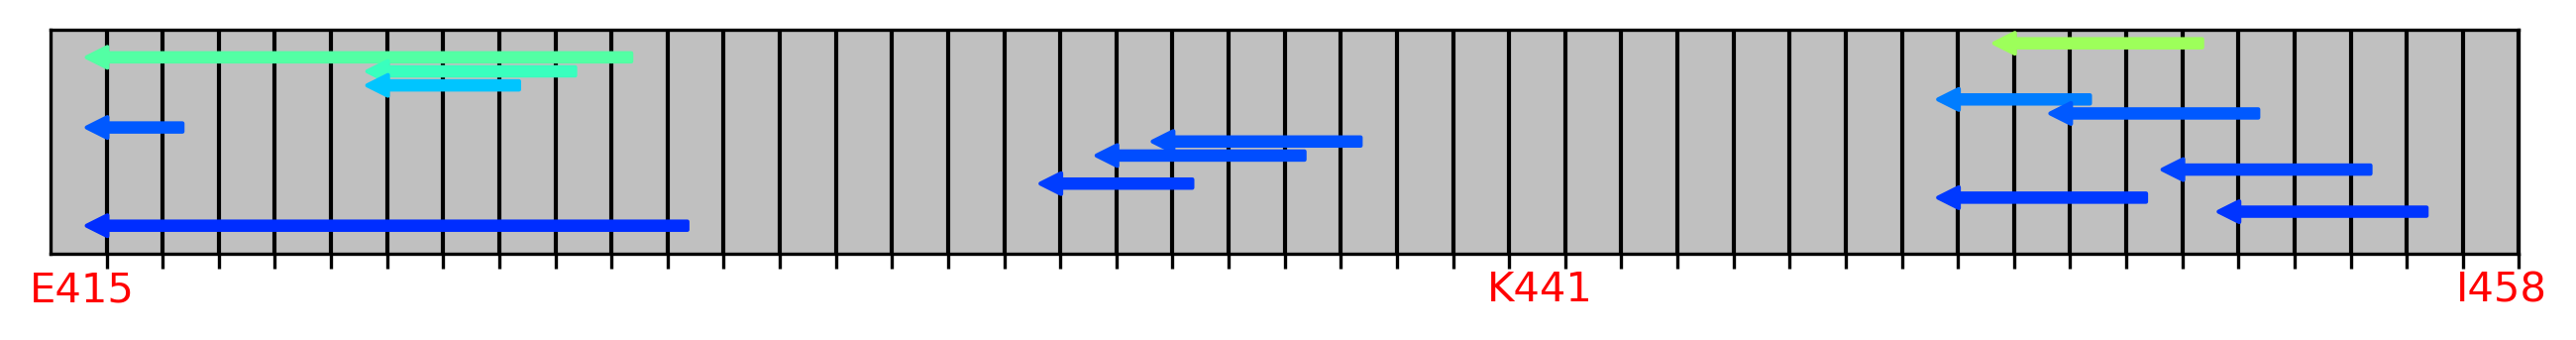

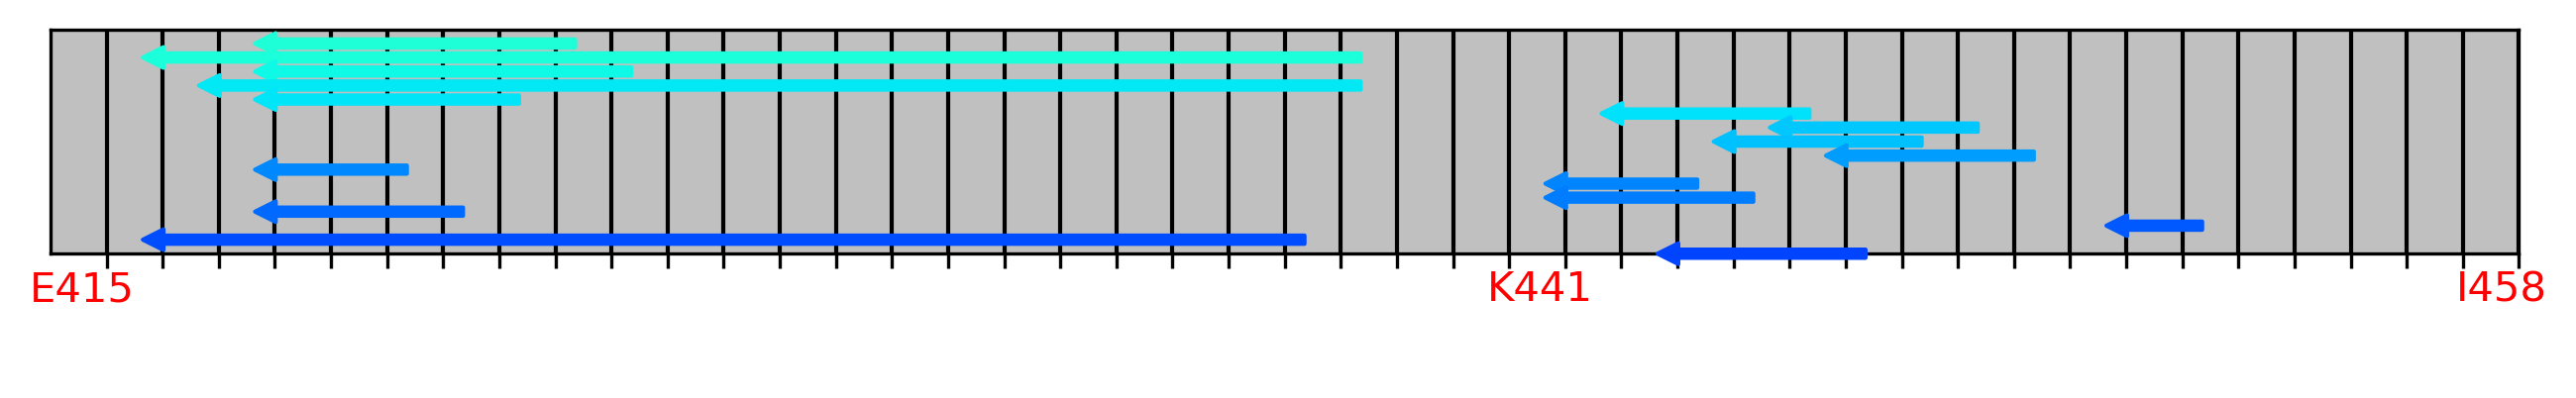

In [13]:
rcParams['figure.dpi']=300
for i in dhdata.keys():
    draw_hbond_figure(Residues,dhdata[i])

dhdata['A454E']

In [14]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

In [15]:
def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(subplot_kw=dict(yticks=[]))
    cax = ax.imshow([colors], extent=[0, 10, 0, 1])
    ax.set_xticklabels(['0.1','0.14','0.28','0.42','0.56','0.7'],rotation=-90,fontsize=16)
    ax.grid(which='major', axis='x', linestyle='--', color='k', linewidth=1)
    #cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    #cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

    #ax.imshow([grayscale], extent=[0, 10, 0, 1])

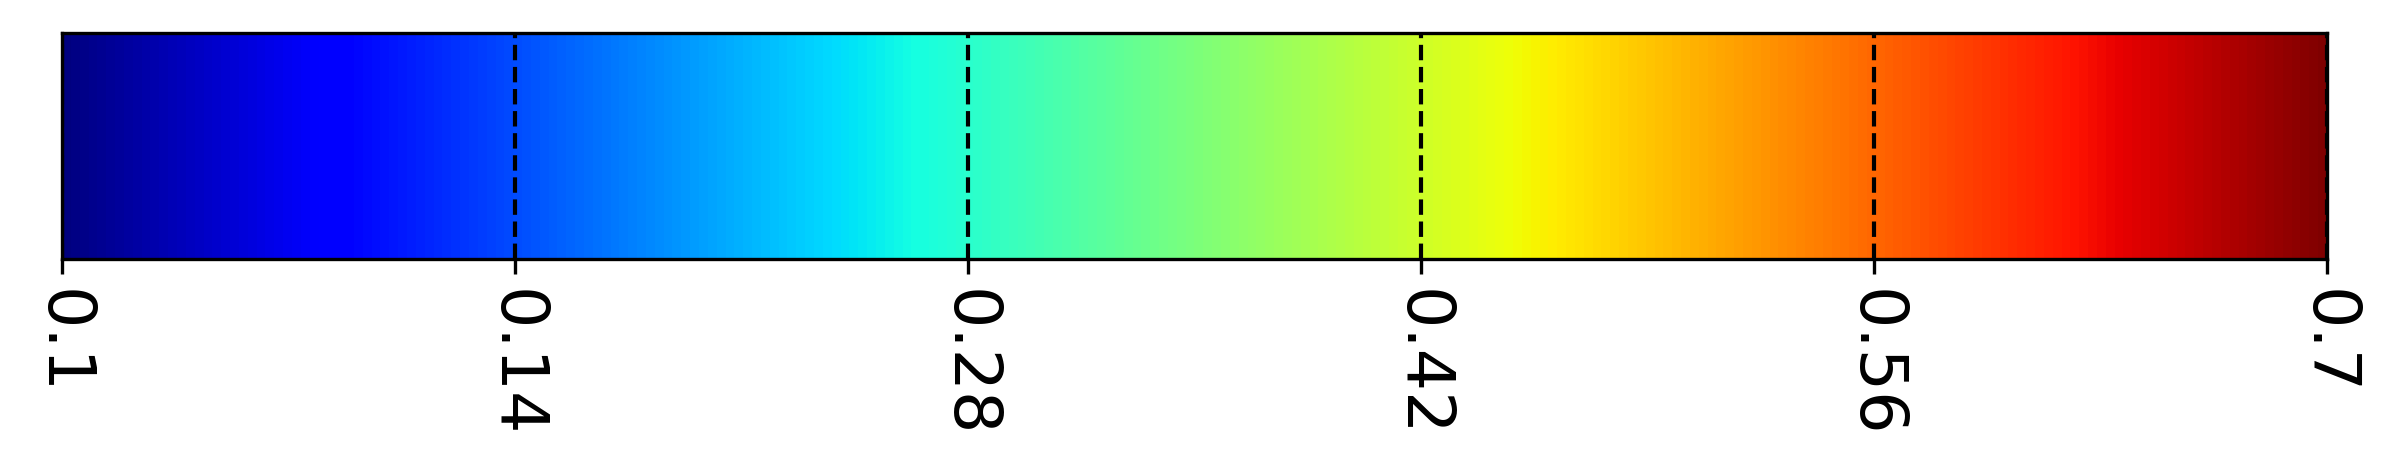

In [16]:
view_colormap('jet')